In [1]:
import FinanceDataReader as fdr
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.3f}'.format

### **종목 선정 모델 개발**

이번절에서는 책에서 종목선정을 위해 사용할 GAM 모델을 개발하겠습니다. 아나콘다에서 제공하지 않으므로 아나콘다 프롬프트에서 conda install -c conda-forge pygam 로 설치를 해 줍니다. 
pip install pygam 으로 설치를 해도 됩니다. 관련 링크 https://anaconda.org/conda-forge/pygam

모델링을 위해 준비한 데이터를 읽습니다. 그리고 모델의 오버피팅을 최소화하기 위하여 타겟변수를 0 과 1 로 치환합니다. 5% 익절은 데이터로 표현하면 다음과 같습니다 - 'max_close' 가 5% 이상일 때 1, 아니면 0. 'max_close' 가 1 인 비율을 보니, 약 24% 입니다. 5000 개 샘플을 뽑아 예측모델을 만들고 나머지로 데이터로 테스트(혹은 백테스팅)를 하겠습니다. 

In [2]:
feature_all = pd.read_pickle('feature_all.pkl') 
feature_all['target'] = np.where(feature_all['max_close']>= 1.05, 1, 0)
target = feature_all['target'].mean()
print(f'% of target:{target: 5.1%}')

% of target: 24.2%


In [50]:
mdl_all = feature_all.drop(columns=['max_close', 'sector']).set_index([feature_all.index,'code'])

train = mdl_all.sample(10000, random_state=124)
test = mdl_all.loc[~mdl_all.index.isin(train.index)]

In [53]:
X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10000 entries, (Timestamp('2021-10-28 00:00:00'), '036800') to (Timestamp('2021-11-05 00:00:00'), '298540')
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price_z             10000 non-null  float64
 1   volume_z            10000 non-null  float64
 2   num_high/close      10000 non-null  float64
 3   num_long            10000 non-null  float64
 4   num_z>1.96          10000 non-null  float64
 5   num_win_market      10000 non-null  float64
 6   pct_win_market      10000 non-null  float64
 7   return over sector  10000 non-null  float64
dtypes: float64(8)
memory usage: 717.0+ KB


In [52]:
from pygam import LogisticGAM, s, f, te, l

X = train.drop(columns='target')
y = train['target']
X_test = test.drop(columns='target')
y_test = test['target']

gam = LogisticGAM(te(0,1) + s(1) + s(2) + f(3) + l(4) + s(5) + s(6) + s(7), verbose=True)
results = gam.gridsearch(X.to_numpy(), y.to_numpy())
print(results.summary())


100% (11 of 11) |########################| Elapsed Time: 0:00:08 Time:  0:00:08


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     24.8502
Link Function:                        LogitLink Log Likelihood:                                  -5391.696
Number of Samples:                        10000 AIC:                                            10833.0923
                                                AICc:                                           10833.2315
                                                UBRE:                                               3.0853
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0234
Feature Function                  Lam

<Figure size 432x288 with 0 Axes>

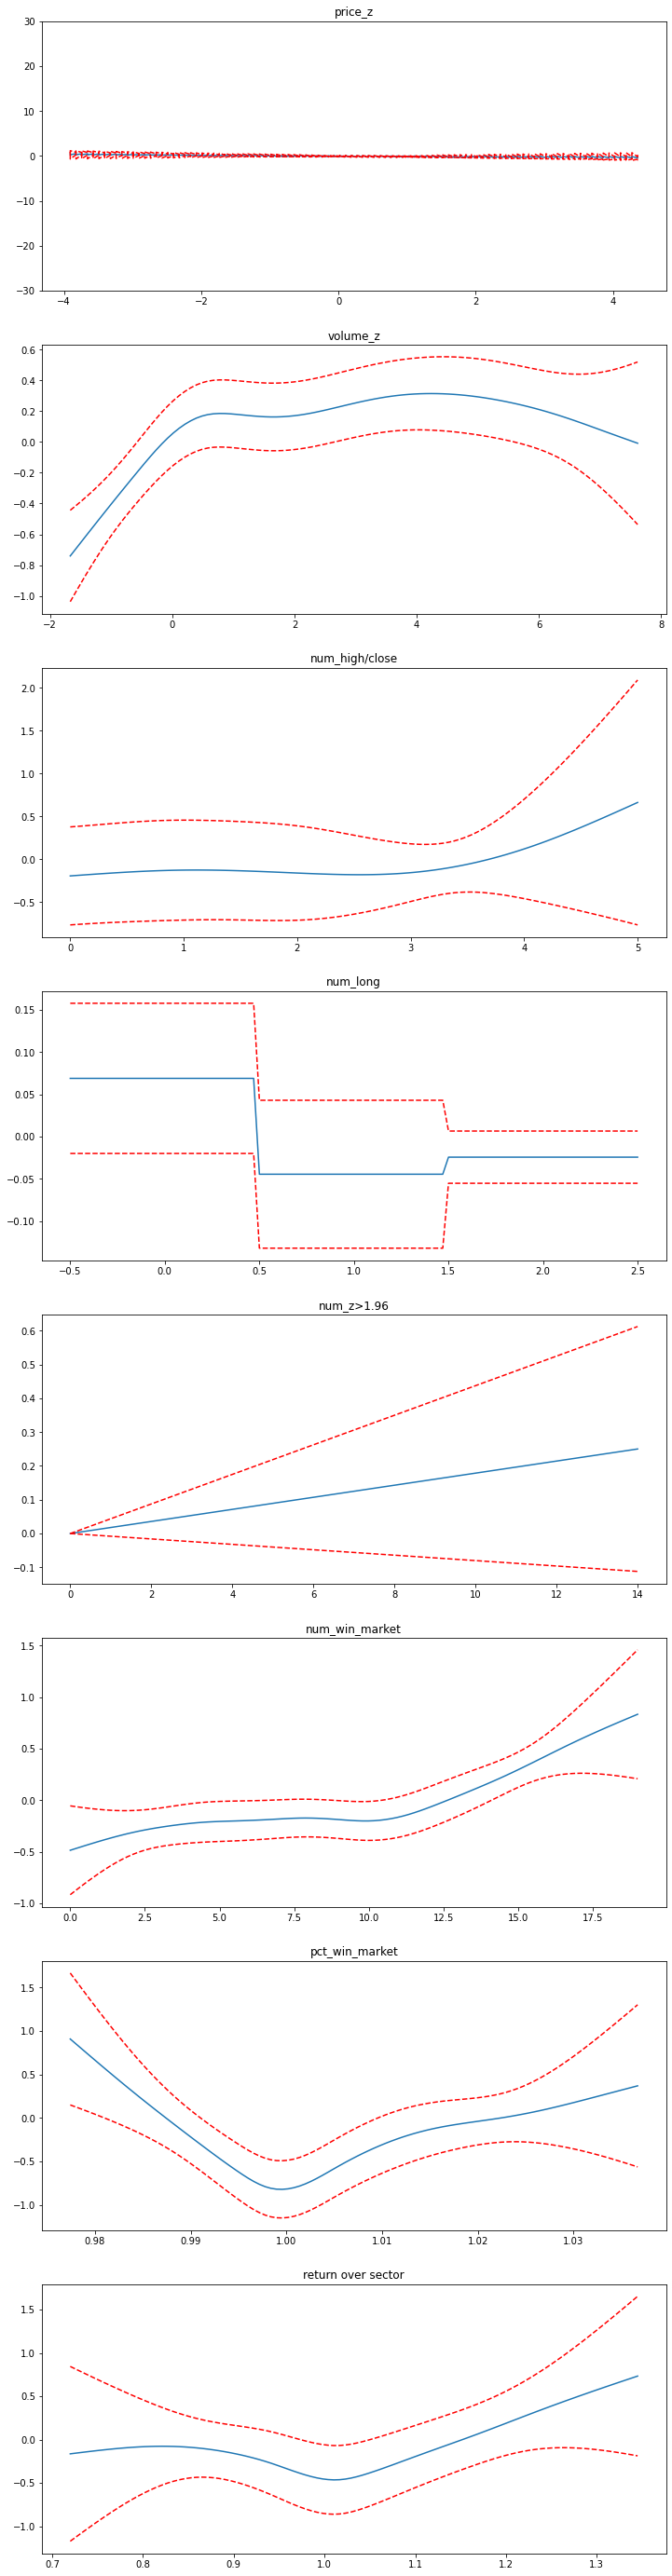

In [54]:
titles = list(train.columns)
plt.figure()
fig, axs = plt.subplots(8, 1, figsize=(12, 50))
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)

    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX,  width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])

In [55]:
yhat = results.predict_proba(X.to_numpy())
yhat = pd.Series(yhat, name='yhat', index=y.index)

yhat_test = results.predict_proba(X_test.to_numpy())
yhat_test = pd.Series(yhat_test, name='yhat', index=y_test.index)

                count  mean
yhat                       
(0.107, 0.178]   1000 0.176
(0.178, 0.194]   1000 0.163
(0.194, 0.206]   1000 0.198
(0.206, 0.216]   1000 0.199
(0.216, 0.227]   1000 0.206
(0.227, 0.24]    1000 0.235
(0.24, 0.255]    1000 0.237
(0.255, 0.276]   1000 0.280
(0.276, 0.316]   1000 0.309
(0.316, 0.751]   1000 0.406
                 count  mean
yhat                        
(0.0756, 0.178]  29255 0.162
(0.178, 0.194]   29254 0.180
(0.194, 0.206]   29254 0.190
(0.206, 0.217]   29255 0.203
(0.217, 0.228]   29254 0.216
(0.228, 0.24]    29254 0.236
(0.24, 0.255]    29255 0.257
(0.255, 0.276]   29254 0.282
(0.276, 0.314]   29254 0.317
(0.314, 0.913]   29255 0.372


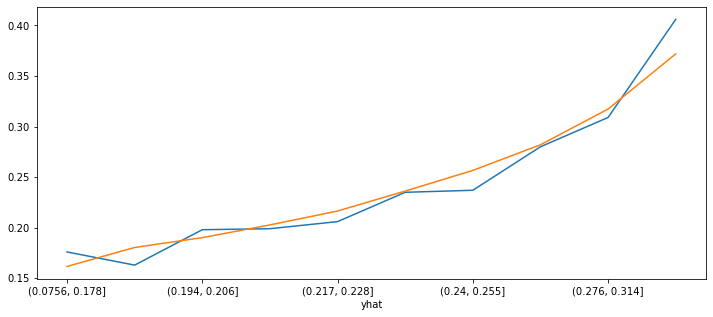

In [56]:
def perf(y, yhat): # Decile 분석 함수
    combined = pd.concat([y, yhat], axis=1)
    ranks = pd.qcut(combined['yhat'], q=10)
    print(combined.groupby(ranks)['target'].agg(['count','mean']))
    combined.groupby(ranks)['target'].mean().plot(figsize=(12,5))

perf(y, yhat)
perf(y_test, yhat_test)